In [1]:
## preliminary
library(tidyverse)
library(gridExtra)
library(patchwork)
library(ggsci)
setwd("/project/Stat/s1155168529/programs/DDML")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




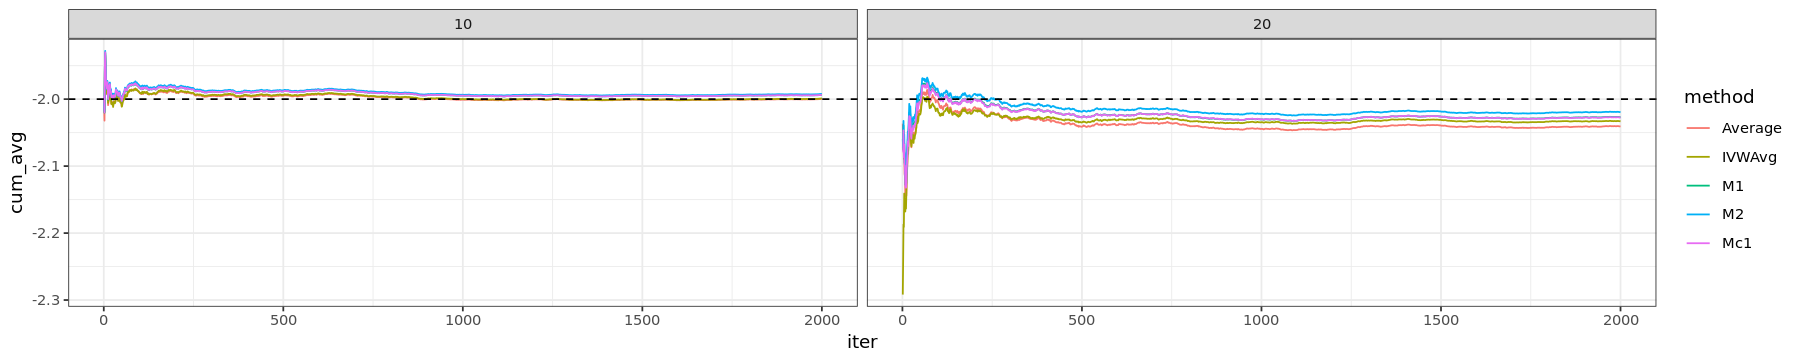

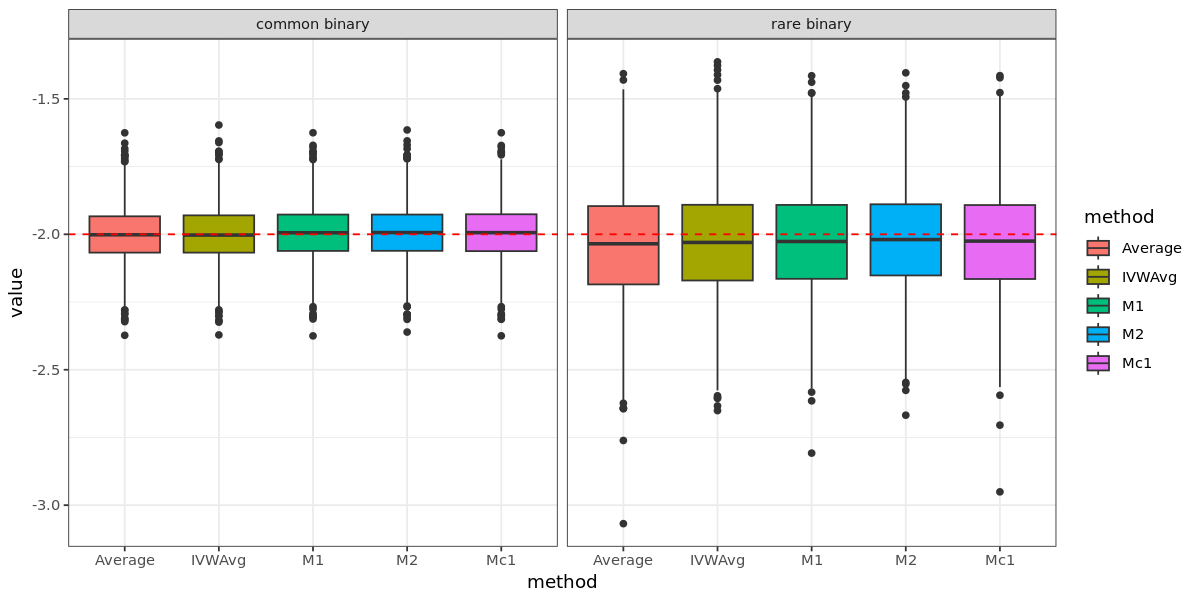

In [2]:
vec_file <- list.files(path = "output")

tib_out <- tibble()

for (
    path_cur in file.path(
        "output", 
        vec_file[str_detect(vec_file, "out_sim2mrf_c5_ip\\d+.csv")] 
    )
) {
    tib_out <- bind_rows(
        tib_out, 
        read_csv(file = path_cur, show_col_types = FALSE) %>% 
            mutate(attr1 = str_extract(path_cur, "(?<=_ip)\\d+") %>% as.numeric())
    )
}

beta <- -2

tib_out <- tib_out %>% 
    filter_at(
        vars(Average:M2), 
        function(x) abs(x - beta) < 2 * abs(beta)
    ) %>% 
    group_by(rnd_np, attr1) %>%
    summarise_at(
        vars(Average:M2),
        mean
    ) %>% 
    mutate()


options(repr.plot.width = 15, repr.plot.height = 3)

tib_out %>%
    pivot_longer(
        cols = Average:M2, 
        names_to = "method",
        values_to = "value"
    ) %>% 
    group_by(attr1, method) %>%
    mutate(
        cum_avg = cumsum(value) / row_number()
    ) %>% 
    mutate(iter = factor(rnd_np) %>% as.numeric()) %>%
    ggplot() + 
    geom_line(
        mapping = aes(x = iter, y = cum_avg, color = method)
    ) +
    geom_hline(yintercept = beta, linetype = "dashed") +
    facet_wrap(~ attr1) + 
    theme_bw() 

options(repr.plot.width = 10, repr.plot.height = 5)

lab_rare_rate <- c(
    "10" = "common binary", 
    "20" = "rare binary"
)

tib_out %>%
    pivot_longer(
        cols = Average:M2, 
        names_to = "method",
        values_to = "value"
    ) %>% 
    filter(method %in% c("Average", "IVWAvg", "Mc1", "M1", "M2")) %>% 
    ggplot() + 
    geom_boxplot(
        mapping = aes(x = method, y = value, fill = method)
    ) + 
    geom_hline(yintercept = beta, linetype = "dashed", color = "red") +
    facet_wrap(~ attr1, labeller = as_labeller(lab_rare_rate)) +
    theme_bw() 

## tag - need to be updated